#**Implement Transformer**
paper: [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/transformer-model-architecture.png)

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 5.7MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Data/ML tutorial'

Mounted at /content/drive


In [3]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
for f in os.listdir(path):
  print(f)

kowiki.txt
kowiki.model
kowiki.vocab
ratings_train.txt
ratings_test.txt
ratings_train.json
ratings_test.json


In [8]:
vocab_file = f'{path}/kowiki.model'
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

lines = [
         "인공위성일까, 별이었으면 좋겠다.",
         "흐린 어둠 사이 왼손으로 그린 별 하나"
]

# convert text into tensor
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
print(inputs.size())
print(inputs)

['▁인', '공', '위', '성', '일', '까', ',', '▁별', '이었', '으면', '▁좋', '겠', '다', '.']
['▁흐', '린', '▁어', '둠', '▁사이', '▁왼', '손', '으로', '▁그린', '▁별', '▁하나']
torch.Size([2, 14])
tensor([[  44, 3662, 3654, 3641, 3620, 3794, 3595,  580,  501, 1663,  760, 4264,
         3589, 3590],
        [1680, 3862,  135, 4966,  328, 2607, 3971,    9, 2363,  580,  324,    0,
            0,    0]])


Input Embedding

In [9]:
n_vocab = len(vocab)
d_hidn = 128
nn_emb = nn.Embedding(n_vocab, d_hidn)

input_embs = nn_emb(inputs)
print(input_embs.size())

torch.Size([2, 14, 128])


Positional Encoding

In [10]:
def get_sinusoid_encoding_table(n_seq, d_hidn):
  def calc_angle(position, i_hidn):
    return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
  def get_pos_angle_vec(position):
    return [calc_angle(position, i_hidn) for i_hidn in range(d_hidn)]

  sinusoid_table = np.array([get_pos_angle_vec(i_seq) for i_seq in range(n_seq)])
  sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
  sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

  return sinusoid_table

(64, 128)


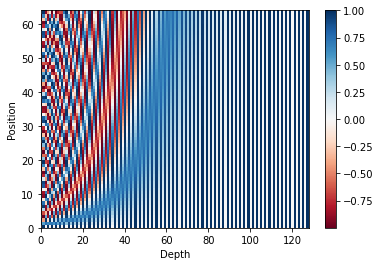

In [12]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print(pos_encoding.shape)
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [14]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions)

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[  44, 3662, 3654, 3641, 3620, 3794, 3595,  580,  501, 1663,  760, 4264,
         3589, 3590],
        [1680, 3862,  135, 4966,  328, 2607, 3971,    9, 2363,  580,  324,    0,
            0,    0]])
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  0,  0]])
torch.Size([2, 14, 128])


In [15]:
input_sums = input_embs + pos_embs

## Scaled Dot Product Attention
![image.png](https://paul-hyun.github.io/assets/2019-12-19/scale_dot_product_attention.png)

In [17]:
# input
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 14, 14])
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, Fal

In [18]:
# 1
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0])

torch.Size([2, 14, 14])
tensor([[154.8909,  25.8306,  28.6320,  50.4145,  51.8330,  33.9185,  48.7074,
          51.2906,  54.3222,  44.3873,  35.5822,  12.2816,  30.0266,  45.9633],
        [ 25.8306, 203.2861,  73.8193,  54.7677,  60.8598,  68.0007,  73.5252,
          49.5928,  28.0489,  66.9485,  34.0314,  49.8470,  51.8058,  53.9442],
        [ 28.6320,  73.8193, 167.5282,  59.1287,  61.2676,  56.4112,  46.0595,
          46.9526,  22.8509,  51.7641,  35.5840,  54.6635,  64.3343,  60.2949],
        [ 50.4145,  54.7677,  59.1287, 223.4592,  65.8988,  82.1945,  49.9719,
          66.2976,  26.2162,  54.7682,  29.5869,  47.0944,  52.0906,  46.5469],
        [ 51.8330,  60.8598,  61.2676,  65.8988, 198.8493,  71.1288,  64.5002,
          67.2721,  52.6532,  51.5685,  28.6901,  36.3606,  42.6053,  56.8189],
        [ 33.9185,  68.0007,  56.4112,  82.1945,  71.1288, 194.6455,  64.7910,
          67.4861,  69.1559,  64.5358,  33.7571,  74.2958,  61.8729,  80.9859],
        [ 48.7074,  73

In [19]:
# 2
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])

torch.Size([2, 14, 14])
tensor([[19.3614,  3.2288,  3.5790,  6.3018,  6.4791,  4.2398,  6.0884,  6.4113,
          6.7903,  5.5484,  4.4478,  1.5352,  3.7533,  5.7454],
        [ 3.2288, 25.4108,  9.2274,  6.8460,  7.6075,  8.5001,  9.1906,  6.1991,
          3.5061,  8.3686,  4.2539,  6.2309,  6.4757,  6.7430],
        [ 3.5790,  9.2274, 20.9410,  7.3911,  7.6585,  7.0514,  5.7574,  5.8691,
          2.8564,  6.4705,  4.4480,  6.8329,  8.0418,  7.5369],
        [ 6.3018,  6.8460,  7.3911, 27.9324,  8.2373, 10.2743,  6.2465,  8.2872,
          3.2770,  6.8460,  3.6984,  5.8868,  6.5113,  5.8184],
        [ 6.4791,  7.6075,  7.6585,  8.2373, 24.8562,  8.8911,  8.0625,  8.4090,
          6.5817,  6.4461,  3.5863,  4.5451,  5.3257,  7.1024],
        [ 4.2398,  8.5001,  7.0514, 10.2743,  8.8911, 24.3307,  8.0989,  8.4358,
          8.6445,  8.0670,  4.2196,  9.2870,  7.7341, 10.1232],
        [ 6.0884,  9.1906,  5.7574,  6.2465,  8.0625,  8.0989, 22.7916,  7.8434,
          7.0722,  8.1443

In [20]:
# 3
scores.masked_fill_(attn_mask, -1e9) # -INF
print(scores.size())
print(scores[0])

torch.Size([2, 14, 14])
tensor([[19.3614,  3.2288,  3.5790,  6.3018,  6.4791,  4.2398,  6.0884,  6.4113,
          6.7903,  5.5484,  4.4478,  1.5352,  3.7533,  5.7454],
        [ 3.2288, 25.4108,  9.2274,  6.8460,  7.6075,  8.5001,  9.1906,  6.1991,
          3.5061,  8.3686,  4.2539,  6.2309,  6.4757,  6.7430],
        [ 3.5790,  9.2274, 20.9410,  7.3911,  7.6585,  7.0514,  5.7574,  5.8691,
          2.8564,  6.4705,  4.4480,  6.8329,  8.0418,  7.5369],
        [ 6.3018,  6.8460,  7.3911, 27.9324,  8.2373, 10.2743,  6.2465,  8.2872,
          3.2770,  6.8460,  3.6984,  5.8868,  6.5113,  5.8184],
        [ 6.4791,  7.6075,  7.6585,  8.2373, 24.8562,  8.8911,  8.0625,  8.4090,
          6.5817,  6.4461,  3.5863,  4.5451,  5.3257,  7.1024],
        [ 4.2398,  8.5001,  7.0514, 10.2743,  8.8911, 24.3307,  8.0989,  8.4358,
          8.6445,  8.0670,  4.2196,  9.2870,  7.7341, 10.1232],
        [ 6.0884,  9.1906,  5.7574,  6.2465,  8.0625,  8.0989, 22.7916,  7.8434,
          7.0722,  8.1443

In [21]:
# 4
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 14, 14])
tensor([[9.9998e-01, 9.8566e-08, 1.3990e-07, 2.1296e-06, 2.5428e-06, 2.7089e-07,
         1.7204e-06, 2.3761e-06, 3.4709e-06, 1.0026e-06, 3.3351e-07, 1.8122e-08,
         1.6654e-07, 1.2208e-06],
        [2.3255e-10, 1.0000e+00, 9.3683e-08, 8.6578e-09, 1.8541e-08, 4.5267e-08,
         9.0301e-08, 4.5340e-09, 3.0685e-10, 3.9688e-08, 6.4818e-10, 4.6804e-09,
         5.9788e-09, 7.8109e-09],
        [2.8825e-08, 8.1816e-06, 9.9998e-01, 1.3042e-06, 1.7039e-06, 9.2856e-07,
         2.5459e-07, 2.8466e-07, 1.3993e-08, 5.1943e-07, 6.8733e-08, 7.4633e-07,
         2.4999e-06, 1.5088e-06],
        [4.0360e-10, 6.9547e-10, 1.1996e-09, 1.0000e+00, 2.7961e-09, 2.1438e-08,
         3.8188e-10, 2.9390e-09, 1.9602e-11, 6.9551e-10, 2.9874e-11, 2.6651e-10,
         4.9767e-10, 2.4888e-10],
        [1.0446e-08, 3.2284e-08, 3.3972e-08, 6.0609e-08, 1.0000e+00, 1.1654e-07,
         5.0888e-08, 7.1961e-08, 1.1574e-08, 1.0106e-08, 5.7890e-10, 1.5101e-09,
         3.2962e-09, 1.9481e-0

In [22]:
# 5
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 14, 128])


In [23]:
class ScaledDotProductAttention(nn.Module):
  '''scaled dot product attention'''

  def __init__(self, d_head):
    super().__init__()
    self.scale = 1 / (d_head ** 0.5)
  
  def forward(self, Q, K, V, attn_mask):
    # (bs, n_head, n_q_seq, n_k_seq)
    scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
    scores.masked_fill_(attn_mask, -1e9)
    # (bs, n_head, n_q_seq, n_k_seq)
    attn_prob = nn.Softmax(dim=-1)(scores)
    # (bs, n_head, n_q_seq, d_v)
    context = torch.matmul(attn_prob, V)
    # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
    return context, attn_prob

## Multi-Head Attention
![](https://paul-hyun.github.io/assets/2019-12-19/multi_head_attention.png)

In [24]:
# input
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

In [25]:
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

In [26]:
# process in detail

# (bs, n_seq, n_head * d_head)
q_s = W_Q(Q)
print(q_s.size())
# (bs, n_seq, n_head, d_head)
q_s = q_s.view(batch_size, -1, n_head, d_head)
print(q_s.size())
# (bs, n_head, n_seq, d_head)
q_s = q_s.transpose(1,2)
print(q_s.size())

torch.Size([2, 14, 128])
torch.Size([2, 14, 2, 64])
torch.Size([2, 2, 14, 64])


In [27]:
# 1~3
# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 14, 64]) torch.Size([2, 2, 14, 64]) torch.Size([2, 2, 14, 64])


In [28]:
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 14, 14])
torch.Size([2, 2, 14, 14])


In [29]:
# 4
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 14, 64])
torch.Size([2, 2, 14, 14])


In [30]:
# 5
# (bs, n_seq, n_head * d_head)
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
print(context.size())

torch.Size([2, 14, 128])


In [31]:
# 6
linear = nn.Linear(n_head * d_head, d_hidn)
# (bs, n_seq, d_hidn)
output = linear(context)
print(output.size())

torch.Size([2, 14, 128])


In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

## Masked Multi Head Attention

In [33]:
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

Q = input_sums
K = input_sums
V = input_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[0])
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[0])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[0])

batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False,

In [34]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 14, 128]) torch.Size([2, 2, 14, 14])


## Feed Forward
![](https://paul-hyun.github.io/assets/2019-12-19/feed-forward.png)

In [35]:
# 1
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())

torch.Size([2, 512, 14])


Activation (relu or gelu)
![](https://paul-hyun.github.io/assets/2019-12-19/activation.png)

In [36]:
# 2
active = F.gelu
ff_2 = active(ff_1)

In [37]:
# 3
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([2, 14, 128])


In [38]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output